
# Setup


## Imports


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from functools import partial
import logging
import pathlib
from pathlib import Path
from pprint import pprint
import sys
from typing import *
import time
import yaml
from yaml import YAMLObject

import humanize
from matplotlib import pyplot as plt, cm
import numpy as np
import pandas as pd
from pymicro.file import file_utils
import tensorflow as tf
from numpy.random import RandomState

from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks as keras_callbacks
from tensorflow.keras import losses
from tensorflow.keras import metrics as keras_metrics

from tomo2seg import modular_unet
from tomo2seg.logger import logger
from tomo2seg import data, viz
from tomo2seg.data import Volume
from tomo2seg.metadata import Metadata
from tomo2seg.volume_sequence import (
    MetaCrop3DGenerator, VolumeCropSequence,
    UniformGridPosition, SequentialGridPosition,
    ET3DUniformCuboidAlmostEverywhere, ET3DConstantEverywhere, 
    GTUniformEverywhere, GTConstantEverywhere, 
    VSConstantEverywhere, VSUniformEverywhere
)
from tomo2seg import volume_sequence
from tomo2seg.model import Model as Tomo2SegModel
from tomo2seg import callbacks as tomo2seg_callbacks
from tomo2seg import losses as tomo2seg_losses


In [3]:
logger.setLevel(logging.DEBUG)

In [7]:
random_state = 42
random_state = np.random.RandomState(random_state)
runid = int(time.time())
# runid = 1606238421
logger.info(f"{runid=}")

INFO::tomo2seg::{<ipython-input-7-f5dd942bd525>:<module>:005}::[2020-11-24::22:44:10.132]
runid=1606254250



In [8]:
logger.debug(f"{tf.__version__=}")
logger.info(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}\nThis should be 2 on R790-TOMO.")
logger.debug(f"Both here should return 2 devices...\n{tf.config.list_physical_devices('GPU')=}\n{tf.config.list_logical_devices('GPU')=}")

# xla auto-clustering optimization (see: https://www.tensorflow.org/xla#auto-clustering)
# this seems to break the training
tf.config.optimizer.set_jit(False)

# get a distribution strategy to use both gpus (see https://www.tensorflow.org/guide/distributed_training)
strategy = tf.distribute.MirroredStrategy()  
# strategy = tf.distribute.MirroredStrategy(devices=[""])  


DEBUG::tomo2seg::{<ipython-input-8-7a7728cf1275>:<module>:001}::[2020-11-24::22:44:10.198]
tf.__version__='2.2.0'

INFO::tomo2seg::{<ipython-input-8-7a7728cf1275>:<module>:002}::[2020-11-24::22:44:10.313]
Num GPUs Available: 2
This should be 2 on R790-TOMO.

DEBUG::tomo2seg::{<ipython-input-8-7a7728cf1275>:<module>:003}::[2020-11-24::22:44:10.689]
Both here should return 2 devices...
tf.config.list_physical_devices('GPU')=[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
tf.config.list_logical_devices('GPU')=[LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU')]

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


# Data

In [9]:
from tomo2seg.datasets import (
    VOLUME_COMPOSITE_V1 as VOLUME_NAME_VERSION,
#     VOLUME_COMPOSITE_V1_REDUCED as VOLUME_NAME_VERSION,
    VOLUME_COMPOSITE_V1_LABELS_REFINED3 as LABELS_VERSION
)

volume_name, volume_version = VOLUME_NAME_VERSION
labels_version = LABELS_VERSION

logger.info(f"{volume_name=} {volume_version=} {labels_version=}")

INFO::tomo2seg::{<ipython-input-9-f863a788f16a>:<module>:010}::[2020-11-24::22:44:10.744]
volume_name='PA66GF30' volume_version='v1' labels_version='refined3'



In [10]:
# Metadata/paths objects

## Volume
volume = Volume.with_check(
    name=volume_name, version=volume_version
)
logger.info(f"{volume=}")

n_classes = len(volume.metadata.labels)

def _read_raw(path_: Path, volume_: Volume): 
    # from pymicro
    return file_utils.HST_read(
        str(path_),  # it doesn't accept paths...
        # pre-loaded kwargs
        autoparse_filename=False,  # the file names are not properly formatted
        data_type=volume.metadata.dtype,
        dims=volume.metadata.dimensions,
        verbose=True,
    )

read_raw = partial(_read_raw, volume_=volume)

logger.info("Loading data from disk.")

## Data
voldata = read_raw(volume.data_path) / 255  # normalize
logger.debug(f"{voldata.shape=}")

voldata_train = volume.train_partition.get_volume_partition(voldata)
voldata_val = volume.val_partition.get_volume_partition(voldata)
logger.debug(f"{voldata_train.shape=} {voldata_val.shape=}")

del voldata

## Labels
vollabels = read_raw(volume.versioned_labels_path(labels_version))
logger.debug(f"{vollabels.shape=}")

vollabels_train = volume.train_partition.get_volume_partition(vollabels)
vollabels_val = volume.val_partition.get_volume_partition(vollabels)
logger.debug(f"{vollabels_train.shape=} {vollabels_val.shape=}")

del vollabels

DEBUG::tomo2seg::{data.py:with_check:237}::[2020-11-24::22:44:10.812]
vol=Volume(name='PA66GF30', version='v1', _metadata=None)

ERROR::tomo2seg::{data.py:with_check:255}::[2020-11-24::22:44:10.814]
Missing file: /home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.labels.raw

Missing file: /home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.weights.raw

DEBUG::tomo2seg::{data.py:metadata:194}::[2020-11-24::22:44:10.817]
Loading metadata from `/home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.metadata.yml`.

INFO::tomo2seg::{<ipython-input-10-81bf4074b174>:<module>:007}::[2020-11-24::22:44:10.822]
volume=Volume(name='PA66GF30', version='v1', _metadata=Volume.Metadata(dimensions=[1300, 1040, 1900], dtype='uint8', labels=[0, 1, 2], labels_names={0: 'matrix', 1: 'fiber', 2: 'porosity'}, set_partitions={'train': {'x_range': [0, 1300], 'y_range': [0, 1040], 'z_range': [0, 1300], 'alias': 'train'}, 'val': {'x_range': [0, 1300], 'y_ran

# Model

In [11]:
try:
    tomo2seg_model
except NameError:
    print("already deleted (:")
else:
    del tomo2seg_model

already deleted (:


In [12]:
model_master_name = "unet-2d-small"
model_version = "vanilla01"

# crop_shape = (256, 256, 1)  # multiple of 16 (requirement of a 4-level u-net)
# bigger crops will have less border effects (?)
crop_shape = (320, 320, 1)  # multiple of 16 (requirement of a 4-level u-net)

model_factory_function = modular_unet.u_net

model_factory_kwargs = dict(
    input_shape = crop_shape,  # add the channe
    nb_filters_0 = 16,
)

In [13]:
try:
    tomo2seg_model
    
except NameError:
    logger.info("Creating a Tomo2SegModel.")
    
    tomo2seg_model = Tomo2SegModel(
        model_master_name, 
        model_version, 
        runid=runid,
        factory_function=model_factory_function,
        factory_kwargs=model_factory_kwargs,
    )
                
else:
    logger.warning("The model is already defined. To create a new one: `del tomo2seg_model`")

finally:
    
    logger.info(f"{tomo2seg_model=}")
    
logger.info("Creating the Keras model.")

with strategy.scope():
    if not tomo2seg_model.autosaved_model_path.exists():
        logger.info(f"Instantiating a new model with model_factory_function={model_factory_function.__name__}")
        model = model_factory_function(
            output_channels=n_classes, 
            name=tomo2seg_model.name,
            **model_factory_kwargs
        )
    else:
        logger.warning("An autosaved model already exists, loading it instead of creating a new one!")
        model = keras.models.load_model(tomo2seg_model.autosaved_model_path_str, compile=False)

    logger.info("Compiling the model.")

    # using the avg jaccard is dangerous if one of the classes is too
    # underrepresented because it's jaccard will be unstable
    loss = tomo2seg_losses.jaccard2_flat

    optimizer = optimizers.Adam(lr=.003)
    metrics = [
#         tomo2seg_losses.jaccard2_macro_avg,
#         keras_metrics.Accuracy(),
    ] + [
        tomo2seg_losses.Jaccard2(class_idx)
        for class_idx in range(n_classes)
    ]

    model.compile(
        loss=loss, 
        optimizer=optimizer,
        metrics=metrics,
    )
    model.save(tomo2seg_model.model_path)

    # write the model summary in a file
    with tomo2seg_model.summary_path.open("w") as f:
        def print_to_txt(line):
            f.writelines([line + "\n"])
        model.summary(print_fn=print_to_txt, line_length=140)

    # same for the architecture
    utils.plot_model(model, show_shapes=True, to_file=tomo2seg_model.architecture_plot_path);

    logger.info(f"Check the summary and the figure of the model in the following locations:\n{tomo2seg_model.summary_path}\n{tomo2seg_model.architecture_plot_path}")

INFO::tomo2seg::{<ipython-input-13-5f50c4ea7e08>:<module>:005}::[2020-11-24::22:44:24.125]
Creating a Tomo2SegModel.

INFO::tomo2seg::{<ipython-input-13-5f50c4ea7e08>:<module>:020}::[2020-11-24::22:44:24.126]
tomo2seg_model=Model(master_name='unet-2d-small', version='vanilla01', fold=0, runid=1606254250, factory_function='tomo2seg.modular_unet.u_net', factory_kwargs={'input_shape': (320, 320, 1), 'nb_filters_0': 16})

INFO::tomo2seg::{<ipython-input-13-5f50c4ea7e08>:<module>:022}::[2020-11-24::22:44:24.127]
Creating the Keras model.

INFO::tomo2seg::{<ipython-input-13-5f50c4ea7e08>:<module>:026}::[2020-11-24::22:44:24.130]
Instantiating a new model with model_factory_function=u_net

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /j

# Data crop sequences

In [14]:
batch_size_per_replica = 8
batch_size = batch_size_per_replica * (n_replicas := strategy.num_replicas_in_sync)

common_random_state = 143

logger.info(f"{batch_size_per_replica=}\n{n_replicas=}\n{batch_size=}\n{common_random_state=}\n{crop_shape=}")

INFO::tomo2seg::{<ipython-input-14-19fcba377971>:<module>:006}::[2020-11-24::22:44:42.218]
batch_size_per_replica=8
n_replicas=2
batch_size=16
common_random_state=143
crop_shape=(320, 320, 1)



## Train

In [15]:
data = voldata_train
labels = vollabels_train
volume_shape = data.shape
labels_list = volume.metadata.labels

crop_seq_train = VolumeCropSequence(
    data_volume=data,
    labels_volume=labels,
    labels=labels_list,
    meta_crop_generator=MetaCrop3DGenerator(
        volume_shape=volume_shape,
        crop_shape=crop_shape,
        x0y0z0_generator=(
            grid_pos_gen := UniformGridPosition.build_from_volume_crop_shapes(
                volume_shape=volume_shape, 
                crop_shape=crop_shape,
                random_state=RandomState(common_random_state),
            )
        ),
        # it is too slow
        et_field=ET3DConstantEverywhere.build_no_displacement(grid_position_generator=grid_pos_gen),
#         et_field=ET3DUniformCuboidAlmostEverywhere.build_half_voxel_cuboid(
#             crop_shape=crop_shape,
#             crop_source_volume_shape=volume_shape,
#             spline_order=1,  # linear interpolation
#             grid_position_generator=grid_pos_gen,
#             random_state=RandomState(common_random_state),
#         ),
        gt_field=GTUniformEverywhere.build_2d(
            random_state=RandomState(common_random_state),
            grid_position_generator=grid_pos_gen,
        ),
        vs_field=VSUniformEverywhere.build_plus_or_mines(
            shift=1. / 255 / 2,  # half a value to both sides +/-
            grid_position_generator=grid_pos_gen,
            random_state=RandomState(common_random_state),
        ),
    ),
    batch_size=batch_size,
    # this volume cropper only returns random crops, 
    #so the number of crops per epoch/batch is w/e i want
#     epoch_size=5,
    epoch_size=1,
    meta_crops_hist_path=tomo2seg_model.train_metacrop_history_path,  # todo add a new path to the model and save this
    debug__no_data_check=True,  # remove me!
    output_as_2d=True
)

INFO::tomo2seg::{volume_sequence.py:build_from_volume_crop_shapes:145}::[2020-11-24::22:44:42.321]
Built UniformGridPosition from volume_shape=(1300, 1040, 1300) and crop_shape=(320, 320, 1) ==> {'x_range': (0, 981), 'y_range': (0, 721), 'z_range': (0, 1300)}

Initializing ET3DConstantEverywhere with a UniformGridPosition.
The {x, y, z}_range values will be overwritten.

Initializing GTUniformEverywhere with a UniformGridPosition.
The {x, y, z}_range values will be overwritten.

Initializing VSUniformEverywhere with a UniformGridPosition.
The {x, y, z}_range values will be overwritten.

DEBUG::tomo2seg::{volume_sequence.py:__post_init__:818}::[2020-11-24::22:44:42.326]
Initializing VolumeCropSequence.

INFO::tomo2seg::{volume_sequence.py:__post_init__:846}::[2020-11-24::22:44:42.327]
A meta crops history file path was given but it still doesn't exist. Writing csv headers.



## Val

In [16]:
# val volume

data = voldata_val
labels = vollabels_val
volume_shape = data.shape
labels_list = volume.metadata.labels

crop_seq_val = VolumeCropSequence(
    # data source
    data_volume=data,
    labels_volume=labels,
    labels=labels_list,
    
    # data augmentation
    meta_crop_generator=MetaCrop3DGenerator(
        volume_shape=volume_shape,
        crop_shape=crop_shape,
        x0y0z0_generator=(
            grid_pos_gen := SequentialGridPosition.build_min_overlap(
                volume_shape=volume_shape, crop_shape=crop_shape,
                # reduce the total number of crops
                n_steps_z=60,
            )
#             grid_pos_gen := SequentialGridPosition.build_from_volume_crop_shapes(
#                 volume_shape=volume_shape, crop_shape=crop_shape,
#                 n_steps_x=2, n_steps_y=2, n_steps_z=200,
#             )
        ),
        et_field=ET3DConstantEverywhere.build_no_displacement(grid_position_generator=grid_pos_gen),
        gt_field=GTConstantEverywhere.build_gt2d_identity(grid_position_generator=grid_pos_gen),
        vs_field=VSConstantEverywhere.build_no_shift(grid_position_generator=grid_pos_gen),
    ),
    
    # others
    batch_size=batch_size,
    epoch_size=len(grid_pos_gen),  # go through all the crops in validation    
    meta_crops_hist_path=None,  # todo add a new path to the model and save this
    debug__no_data_check=True,  # remove me!
    output_as_2d=True,
)

INFO::tomo2seg::{volume_sequence.py:build_min_overlap:202}::[2020-11-24::22:44:42.414]
Building SequentialGridPosition with minimal overlap (smallest n_steps in each directions) n_steps={'n_steps_x': 5, 'n_steps_y': 4, 'n_steps_z': 300}.

n_steps_kwargs={'n_steps_z': 60} was given --> effective n_steps={'n_steps_x': 5, 'n_steps_y': 4, 'n_steps_z': 60}

INFO::tomo2seg::{volume_sequence.py:build_from_volume_crop_shapes:145}::[2020-11-24::22:44:42.416]
Built SequentialGridPosition from volume_shape=(1300, 1040, 300) and crop_shape=(320, 320, 1) ==> {'x_range': (0, 981), 'y_range': (0, 721), 'z_range': (0, 300)}

INFO::tomo2seg::{volume_sequence.py:__post_init__:184}::[2020-11-24::22:44:42.421]
The SequentialGridPosition has len(self.positions)=1200 different positions (therefore crops).

Initializing ET3DConstantEverywhere with a SequentialGridPosition.
The {x, y, z}_range values will be overwritten.

Initializing GTConstantEverywhere with a SequentialGridPosition.
The {x, y, z}_range val

# Callbacks

In [17]:
autosave_cb = keras_callbacks.ModelCheckpoint(
    tomo2seg_model.autosaved_model_path_str, 
    monitor="val_loss", 
    verbose=2, 
    save_best_only=True, 
    mode="auto",
)

# todo load if it already exists
try:
    history_cb
    
except NameError:
    history_cb = tomo2seg_callbacks.History(
        optimizer=model.optimizer,
        crop_seq_train=crop_seq_train,
        crop_seq_val=crop_seq_val,
        backup=1,
        csv_path=tomo2seg_model.history_path,
    )
    
else:
    logger.warning("The history callback already exists!")
    
    history_df = history_cb.dataframe

    try:
        history_df_temp = pd.read_csv(tomo2seg_model.history_path)
        # keep the longest one
        history_df = history_df if history_df.shape[0] >= history_df_temp.shape[0] else history_df_temp
        del history_df_temp
    
    except FileNotFoundError:
        logger.info("History hasn't been saved yet.")
        
    except EmptyDataError:
        logger.info("History hasn't been saved yet.")
        
finally:
    # make sure the correct objects are linked 
    history_cb.model = model
    history_cb.crop_seq_train = crop_seq_train
    history_cb.crop_seq_val = crop_seq_val
    # todo do the same with other objs in history_cb

# Summary before training

stuff that i use after the training but i want it to appear in the 


## Metadata

todo put this back to work

## Volume slices

todo put this back to work

## Generator samples

todo put this back to work

# Learning rate range test

todo put this back to work


# Training


## Triangular log lr schedule

In [18]:
from tomo2seg.schedule import ComposedSchedule, LogSpaceSchedule

In [19]:
# from tensorflow.keras import backend as K
# lr = 0.001
# K.set_value(model.optimizer.learning_rate, lr)

lr_schedule_cb = keras_callbacks.LearningRateScheduler(
#     schedule=log_schedule_factory(-6, -2, 9, 9),
#     schedule=log_schedule_factory(-2, -1, 13, 0, offset_epoch=61),
    schedule=ComposedSchedule(
        offset_epoch=0,
        sub_schedules=[
            LogSpaceSchedule(0, wait=0, start=-4, stop=-2, n_between_scales=11),
            LogSpaceSchedule(25, wait=0, start=-2, stop=-4, n_between_scales=19),
            LogSpaceSchedule(146, wait=0, start=-4, stop=-5, n_between_scales=18),
        ]
    ),
    verbose=2,
)

crop_seq_train.epoch_size = 10

callbacks = [
    autosave_cb,
    history_cb,
    keras_callbacks.TerminateOnNaN(),
    lr_schedule_cb
]

INFO::tomo2seg::{schedule.py:__post_init__:071}::[2020-11-24::22:44:42.616]
LogSpaceSchedule ==> self.n=25

INFO::tomo2seg::{schedule.py:__post_init__:071}::[2020-11-24::22:44:42.618]
LogSpaceSchedule ==> self.n=121

INFO::tomo2seg::{schedule.py:__post_init__:071}::[2020-11-24::22:44:42.619]
LogSpaceSchedule ==> self.n=20

INFO::tomo2seg::{schedule.py:__post_init__:107}::[2020-11-24::22:44:42.619]
ComposedSchedule ==> self.n=166



In [ ]:
%%capture
n_epochs = 166

model.fit(
    # data sequences
    x=crop_seq_train,
    validation_data=crop_seq_val,
    
    # epochs
    initial_epoch=0,
    epochs=n_epochs,
#     initial_epoch=history_cb.last_epoch + 1,  # for some reason it is 0-starting and others 1-starting...
#     epochs=history_cb.last_epoch + 1 + n_epochs,  
    
    # others
    callbacks=callbacks,  
    verbose=2,
    use_multiprocessing=False,   
);

INFO:tensorflow:batch_all_reduce: 135 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 135 all-reduces with algorithm = nccl, num_packs = 1
INFO::tomo2seg::{callbacks.py:on_epoch_end:082}::[2020-11-24::22:52:24.104]
Saving backup of the training history epoch=0 self.csv_path=PosixPath('/home/users/jcasagrande/projects/tomo2seg/data/models/unet-2d-small.vanilla01.000.1606-254-250/history.csv')

INFO::tomo2seg::{callbacks.py:on_epoch_end:082}::[2020-11-24::22:56:02.894]
Saving backup of the training history epoch=1 self.csv_path=PosixPath('/home/users/jcasagrande/projects/tomo2seg/data/models/unet-2d-small.vanilla01.000.1606-254-250/history.csv')

INFO::tomo2seg::{callbacks.py:on_epoch_end:082}::[2020-11-24::22:59:40.993]
Saving backup of the training history epoch=2 self.csv_path=PosixPath('/home/users/jcasagrande/projects/tomo2seg/data/models/unet-2d-small.vanilla01.000.1606-254-250/history.csv')

INFO::tomo2seg::{callbacks.py:on_epoch_end:082}::[2020-

# History

DEBUG::tomo2seg::{viz.py:plot:294}::[2020-11-25::10:11:48.172]
TrainingHistoryDisplay.plot plotting loss

INFO::tomo2seg::{viz.py:mark_min_values:389}::[2020-11-25::10:11:48.207]
train: argmin=21 --> min=0.0239

INFO::tomo2seg::{viz.py:mark_min_values:389}::[2020-11-25::10:11:48.210]
val: argmin=24 --> min=0.273



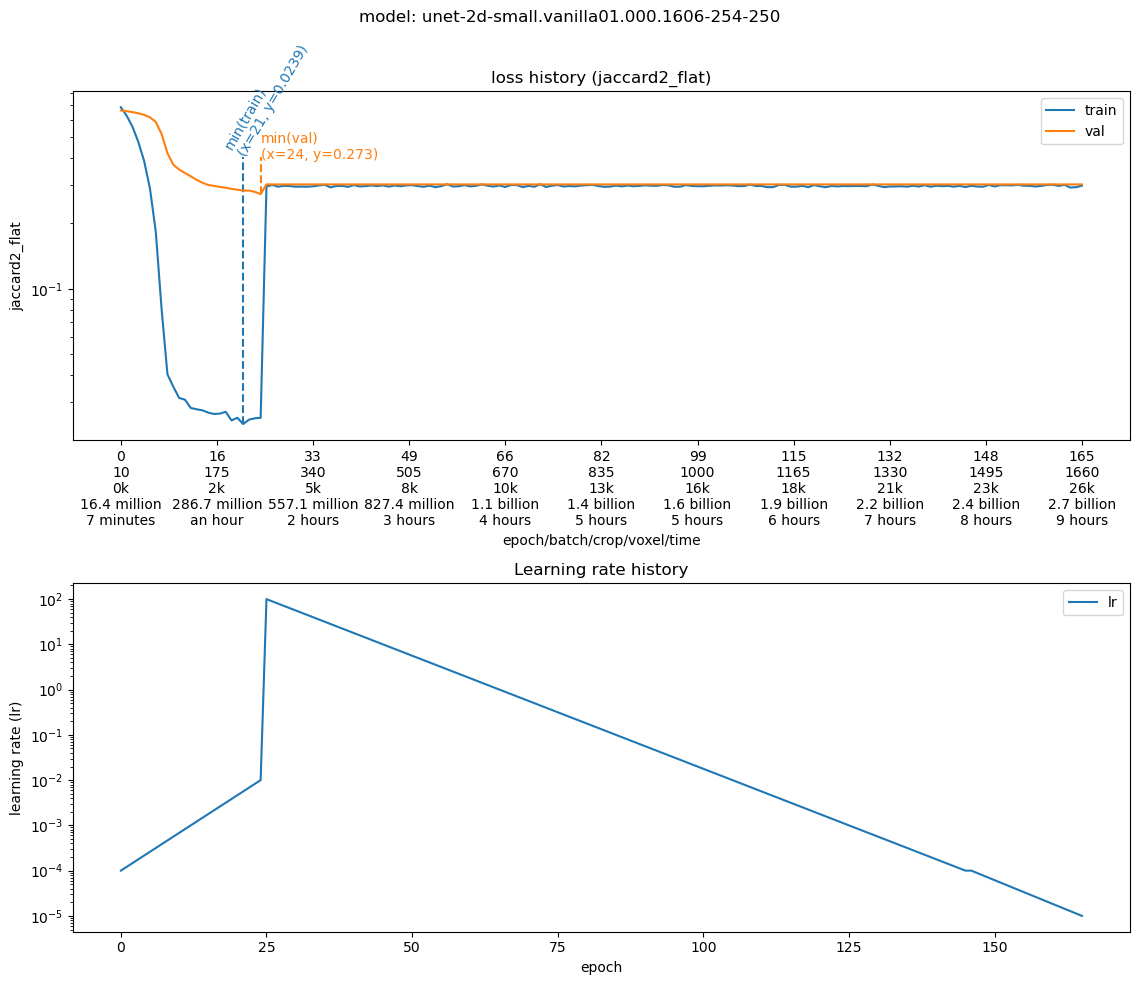

In [96]:
fig, axs = plt.subplots(nrows := 2, ncols := 1, figsize=(2.3 * (sz := 5), nrows * sz), dpi=100)
fig.set_tight_layout(True)

hist_display = viz.TrainingHistoryDisplay(
    history_cb.history, 
    model_name=tomo2seg_model.name,
    loss_name=model.loss.__name__,
    x_axis_mode=(
        "epoch", 
        "batch",
        "crop", 
        "voxel",
        "time",
    ),
).plot(
    axs, 
    with_lr=True,
    metrics=(
        "loss", 
#         "jaccard2.class_idx=0",
#         "jaccard2.class_idx=1",
#         "jaccard2.class_idx=2",
    ),
)

axs[0].set_yscale("log")
axs[-1].set_yscale("log")

viz.mark_min_values(hist_display.axs_metrics_[0], hist_display.plots_["loss"][0])
viz.mark_min_values(hist_display.axs_metrics_[0], hist_display.plots_["val_loss"][0], txt_kwargs=dict(rotation=0))

hist_display.fig_.savefig(
    tomo2seg_model.model_path / (hist_display.title + ".png"),
    format='png',
)
# plt.close()

In [ ]:
history_cb.dataframe.to_csv(history_cb.csv_path, index=True)

In [ ]:
model.save(tomo2seg_model.model_path)